## mlbotのチュートリアル

前提

- 研究の足がかりとなるもの
- そのままでは儲からない
- 執筆中

改良のポイント

- 執行の改善 (y計算に使う指値価格などを工夫すると良いかも)
- CVの改善 (厳密にリークを防いだり、ハイパーパラメータチューニング用にnested cvにするなどの改良がありえる)
- 機械学習で使われる一般的なテクニック (baggingなど)

## 補足

### コードブロック単位でpklに保存し、次のコードブロックで読み込む処理について

同じコードブロックを何回実行しても結果を同じにするためです。
pklに保存せずにdfに入れたままにしておくと、
試行錯誤しているうちにdfが変な状態になってしまい、
変な結果になることがあります。それを防げます。
pklを使う理由は読み書きが速いからです。
ただし、pklは互換性が低いので(pandasのバージョンが異なると読み込めなかったりする)、
データを他環境でも使いたい場合はparquetなどがおすすめです。

In [3]:
# 必要なライブラリのインポート

from collections import defaultdict
import json
import math
import os
import re
import time

import ccxt
from crypto_data_fetcher.gmo import GmoFetcher
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm, pearsonr, spearmanr, ttest_1samp, ttest_ind
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import talib
from joblib import Memory

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.preprocessing import QuantileTransformer

# pandasの表示設定(結果には影響を与えない)
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

# pandasの警告を消す設定(結果には影響を与えない)
# pd.options.mode.chained_assignment = None


In [2]:
df = pd.read_csv('https://api.coin.z.com/data/trades/BTC_JPY/2018/10/20181001_BTC_JPY.csv.gz')
display(df)

,symbol,side,size,price,timestamp
0,BTC_JPY,BUY,0.25,743631.0,2018-09-30 21:12:12.843
1,BTC_JPY,BUY,0.25,743631.0,2018-09-30 21:12:13.354
2,BTC_JPY,BUY,0.25,743631.0,2018-09-30 21:12:14.377
3,BTC_JPY,BUY,0.25,743631.0,2018-09-30 21:12:15.884
4,BTC_JPY,BUY,0.25,743631.0,2018-09-30 21:12:16.412
...,...,...,...,...,...
3604,BTC_JPY,SELL,0.01,747800.0,2018-10-01 20:54:08.524
3605,BTC_JPY,SELL,0.01,747800.0,2018-10-01 20:54:09.550
3606,BTC_JPY,SELL,0.01,747800.0,2018-10-01 20:54:10.567
3607,BTC_JPY,SELL,0.01,747800.0,2018-10-01 20:54:11.808


## データを用意

以下では、例としてFTXのBTC-PERPの5分足を取得します。
データ取得用のライブラリ https://github.com/richmanbtc/crypto_data_fetcher を利用していますが、
やっていることは取引所APIを呼んでいるだけです。

## 改良ポイント

### 取引所と取引ペア選び

FTX以外の取引所やBTC-PERP以外のペアを試すと良いかもしれません。
取引ペアごとに値動きの傾向は変わります。
同じペアでも取引所ごとに値動きの傾向は変わります。

### 時間軸(足の間隔)変更

時間軸によって値動きの傾向が変わります。
学習、統計的検定などにも影響を与えます。

時間軸が短いメリット

- 値動きを予測しやすい
- サンプル数が多くなり、統計的に有意になりやすい
- サンプル数が多くなり、学習が成功しやすい

時間軸が長いメリット

- バックテストと実際の誤差が出づらい (APIや取引所の処理遅延など)
- 運用資金をスケールさせやすい

In [7]:
memory = Memory('/tmp/gmo_fetcher_cache', verbose=1)
fetcher = GmoFetcher(memory=memory)

# GMOコインのBTC/JPYレバレッジ取引 (https://api.coin.z.com/data/trades/BTC_JPY/)を取得
df = fetcher.fetch_ohlcv(
    market='BTC_JPY', # 市場のシンボルを指定
    interval_sec=5 * 60, # 足の間隔を秒単位で指定。この場合は5分足
)

display(df)
df.to_pickle('df_ohlcv.pkl')

,op,hi,lo,cl,volume
timestamp,,,,,
2018-09-05 08:05:00+00:00,818724.0,818724.0,818724.0,818724.0,0.01
2018-09-05 08:20:00+00:00,821250.0,821250.0,821250.0,821250.0,0.01
2018-09-05 08:45:00+00:00,819260.0,819282.0,819260.0,819282.0,0.02
2018-09-05 08:50:00+00:00,819765.0,819765.0,819765.0,819765.0,0.01
2018-09-05 09:00:00+00:00,820000.0,820000.0,819500.0,819500.0,0.02
...,...,...,...,...,...
2021-09-29 20:35:00+00:00,4592401.0,4600981.0,4587880.0,4590779.0,11.35
2021-09-29 20:40:00+00:00,4589695.0,4600696.0,4583562.0,4590600.0,13.57
2021-09-29 20:45:00+00:00,4592171.0,4596296.0,4585800.0,4593097.0,5.60


## 特徴量エンジニアリング

以下ではテクニカル指標計算ライブラリの[TA-Lib](https://mrjbq7.github.io/ta-lib/)を利用して特徴量を作成しています。

## 改良ポイント

### 特徴量の改善

後述のrichman non-stationarity scoreが下がるような特徴量を探すと良いと思います。
以下のようなTA-Lib以外のライブラリを試すのも良いと思います。

- https://github.com/bukosabino/ta

In [9]:


def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    print('calc talib overlap')
    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    print('calc talib momentum')
    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    print('calc talib volume')
    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    print('calc talib vola')
    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    print('calc talib cycle')
    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    print('calc talib stats')
    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df

df = pd.read_pickle('df_ohlcv.pkl')
df = df.dropna()
df = df.reset_index()
df = df[df['timestamp'] < pd.to_datetime('2021-01-01 00:00:00Z')] # テスト期間を残せるように少し前で設定
df = calc_features(df)

df = df.set_index('timestamp')
display(df)
df.to_pickle('df_features.pkl')

calc talib overlap
calc talib momentum
calc talib volume
calc talib vola
calc talib cycle
calc talib stats


,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-09-05 08:05:00+00:00,818724.0,818724.0,818724.0,818724.0,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-05 08:20:00+00:00,821250.0,821250.0,821250.0,821250.0,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-05 08:45:00+00:00,819260.0,819282.0,819260.0,819282.0,0.02,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-05 08:50:00+00:00,819765.0,819765.0,819765.0,819765.0,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-05 09:00:00+00:00,820000.0,820000.0,819500.0,819500.0,0.02,1645.101961,-45.8,-1736.701961,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,845.450980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:35:00+00:00,2999521.0,3001550.0,2995004.0,3000311.0,19.88,12405.080719,4581.6,-3241.880719,10394.914061,4733.730021,...,-0.762226,-0.081257,0,0.523204,0.816192,559.171429,-89.937168,12413.685714,-911.885714,3911.740359
2020-12-31 23:40:00+00:00,3000311.0,3000311.0,2982170.0,2984264.0,52.31,21005.598054,6634.9,-7735.798054,14725.273568,10560.763568,...,-0.596210,0.146102,0,-0.466051,0.824056,11035.085714,-89.961909,30589.485714,-1504.184615,7185.349027
2020-12-31 23:45:00+00:00,2984265.0,2998908.0,2978610.0,2998908.0,74.01,21701.559337,8244.8,-5211.959337,16576.813893,12855.601402,...,-0.436903,0.327112,0,-0.405689,0.846201,-4307.514286,-89.961171,14875.371429,-1475.606593,6728.379668


## 学習に使う特徴量の定義

以下では学習に使う特徴量を定義しています。

In [10]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
    'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
    'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

## richman non-stationarity score (執筆中)

以下では、richman non-stationarity scoreを使い、特徴量の非定常性を測っています。
richman non-stationarity scoreはrichmanbtcが考案した非定常性の度合いを測る指標です。

特徴量の定常性の度合いが低いと、汎化性能が悪化する可能性があるので、
scoreが低くなるように特徴量エンジニアリングを行います。
0.3以下が目安です。

## 特徴量分布の定常性の度合いが低いと汎化性能が悪化する理由

特徴量分布が定常だと、未来でも同じ分布になることが期待できます。
一方、定常でないと、時刻によって特徴量分布が変わるので、
未来の特徴量分布が学習データの特徴量分布と異なる可能性があります。
その場合、学習データに無いデータを予測することになるので、
性能が劣化する可能性があります。

## richman non-stationarity scoreの計算方法

計算に必要なパラメータ: 回帰モデル、CVのfold数

1. シャッフル付きKFold CVで以下の2, 3を計算し、R2の平均をrichman non-stationarity scoreとする
2. 特徴量からサンプルインデックス(時刻でも良い)を与えられた回帰モデルで学習
3. validationデータに対して、サンプルインデックスを予測し、予測精度をR2で評価

この例では回帰モデルはデフォルトパラメータのlgbm、CVのfolds数は2を選んでいます。

## richman non-stationarity scoreの特徴量重要度

ツリー系モデルを使うと、重要度を表示できるので便利です。
重要度の高いものが定常性を劣化させていることがわかります。

## 参考リンク

- [時系列予測での特徴量選択](https://note.com/btcml/n/na4376bc5c336)
- [Kaggleで役立つAdversarial Validationとは](https://www.acceluniverse.com/blog/developers/2020/01/kaggleadversarial-validation.html)


dfは特徴量が入ったDataFrame
featuresは使う特徴量カラム名配列
重要度表示。重要度が高いものは汎化性能に悪影響を与える可能性がある


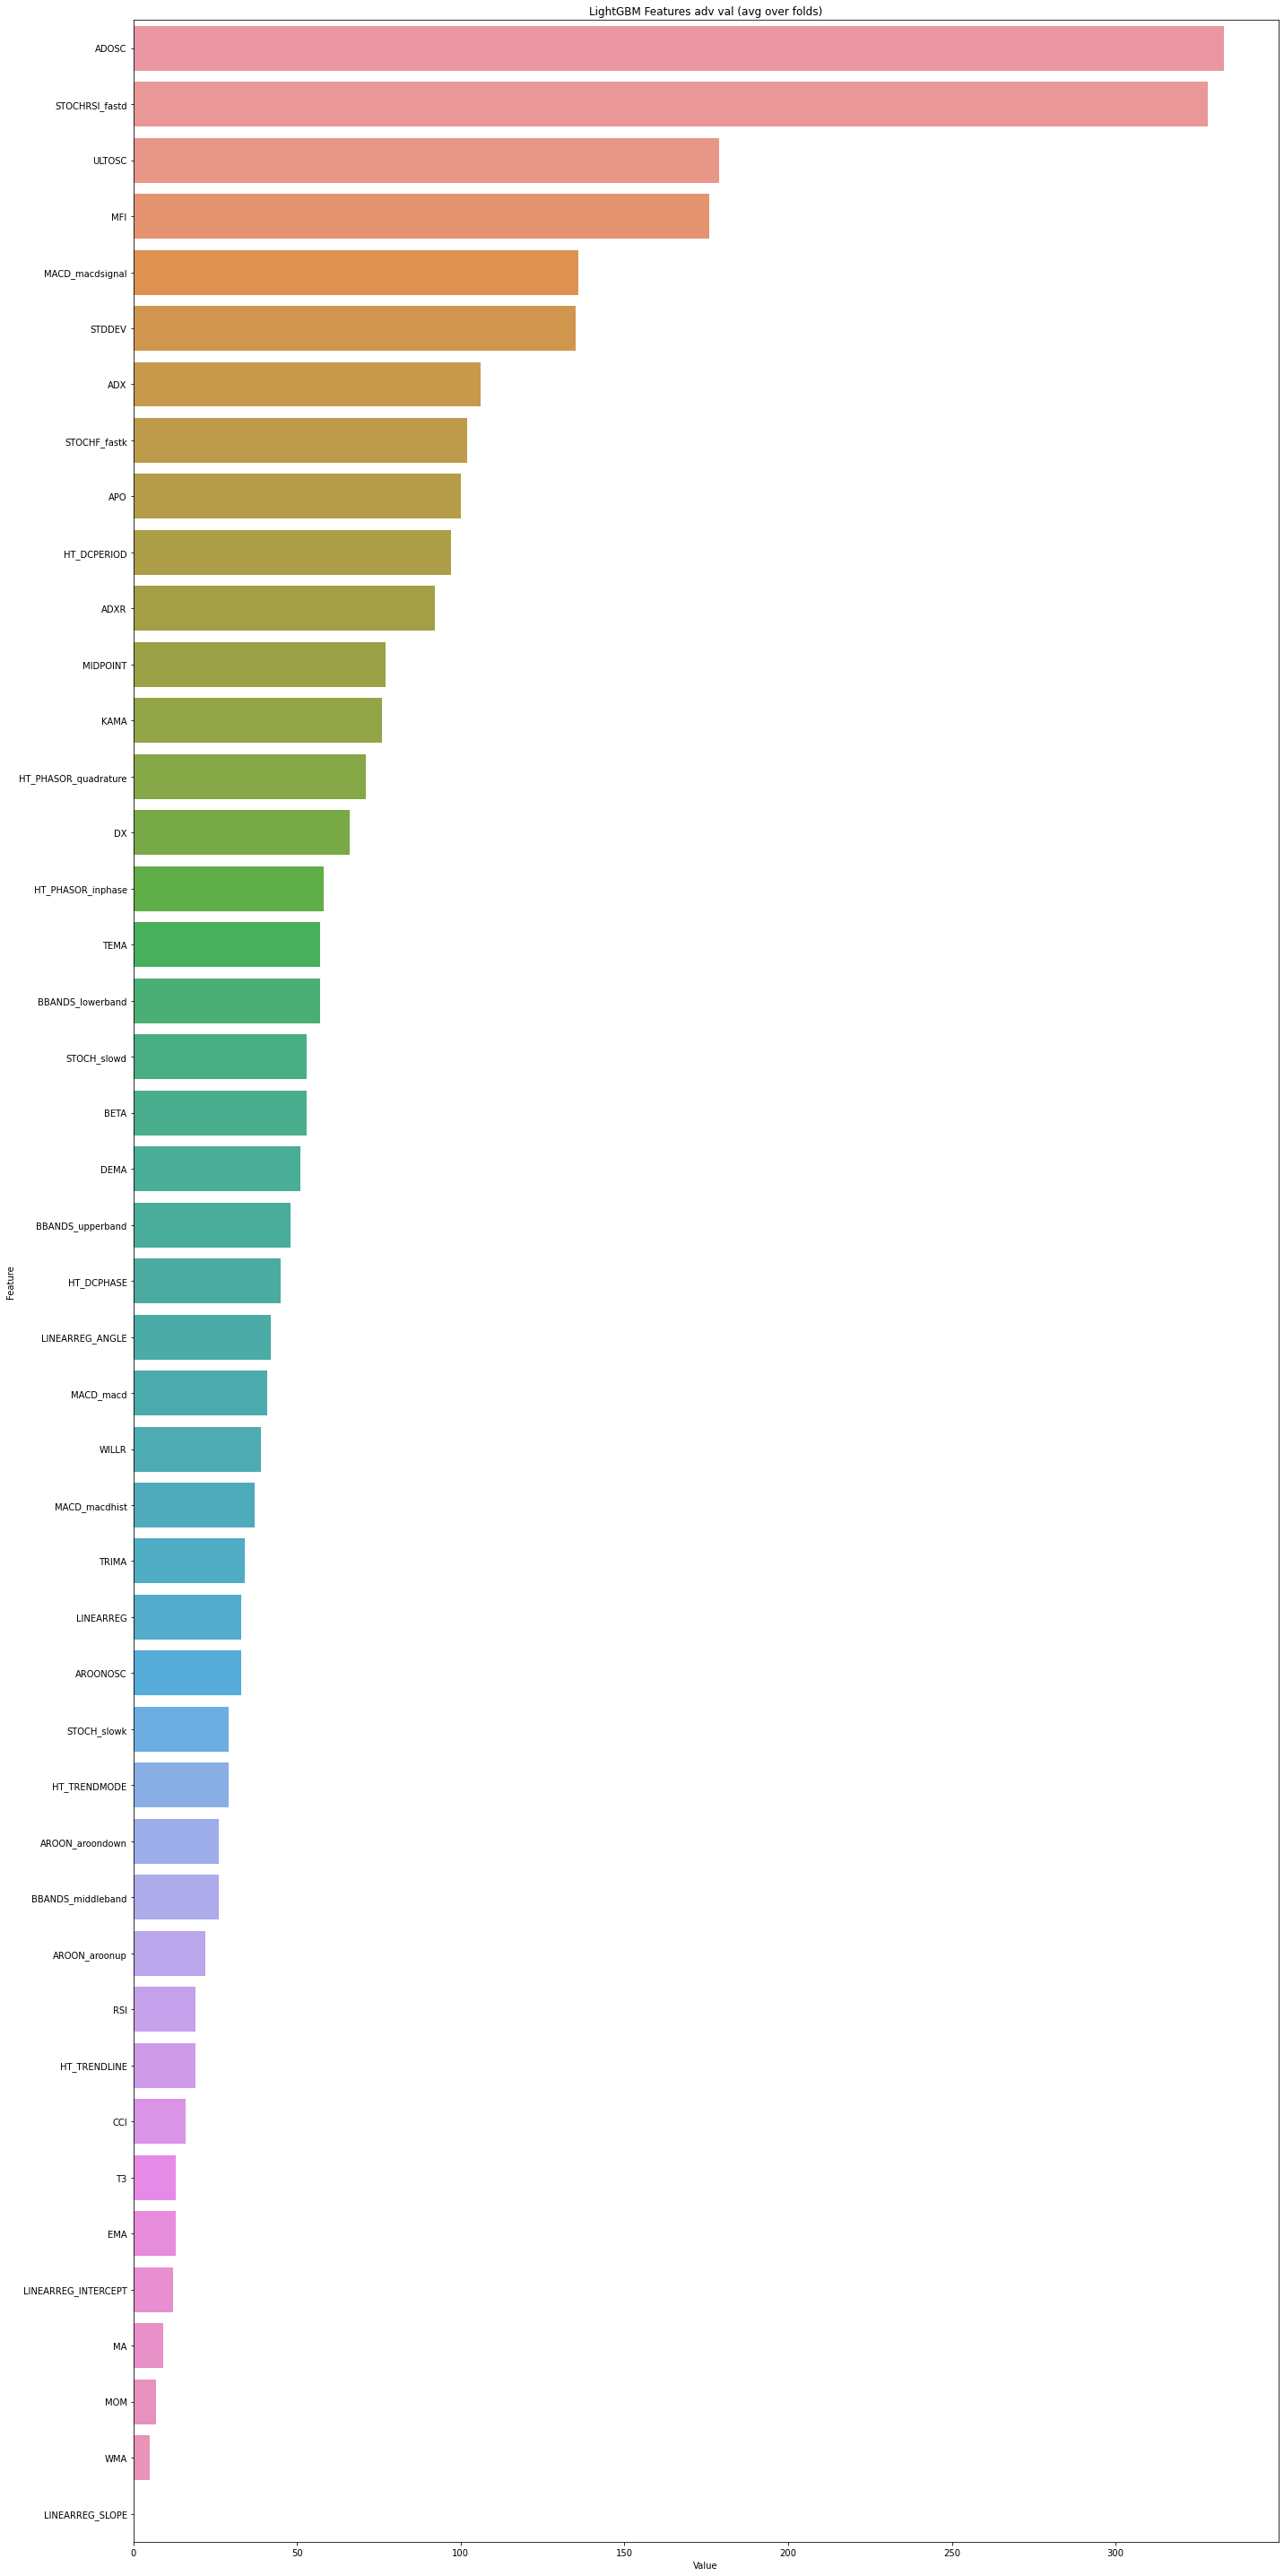

スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)
scores [0.29765083 0.29383043]
score mean, std 0.29574062838397575 0.0019102001900472843


In [11]:
df = pd.read_pickle('df_features.pkl')

print('dfは特徴量が入ったDataFrame')
print('featuresは使う特徴量カラム名配列')

print('重要度表示。重要度が高いものは汎化性能に悪影響を与える可能性がある')
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)
model.fit(df[features], np.arange(df.shape[0]))
lgbm_adv_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features adv val (avg over folds)')
plt.tight_layout()
plt.show()

print('スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)')
cv = KFold(n_splits=2, shuffle=True, random_state=0)
scores = cross_val_score(model, df[features], np.arange(df.shape[0]), scoring='r2', cv=cv)
print('scores', scores)
print('score mean, std', np.mean(scores), np.std(scores))

## 目的変数(y)の計算 (執筆中)

以下では目的変数(y)を計算しています。
実際の取引ルールに従ってトレードした場合に得られるリターンをyとしています。

## なにをyとするか？

コスト込みリターンをyとするのが一つの方法です。

## force entry price

calc_force_entry_priceで計算します。

## 改良のポイント

### 執行の改善


### 指値価格の計算方法

指値価格は例としてATRで計算していますが、
他の計算方法に変えると改善するかもしれません。

### コスト込みリターン以外をyとする

他にも上下を-1, 1で分類問題として解くなど、いろいろ工夫は考えられます。

## 参考リンク

- https://note.com/btcml/n/n9f730e59848c


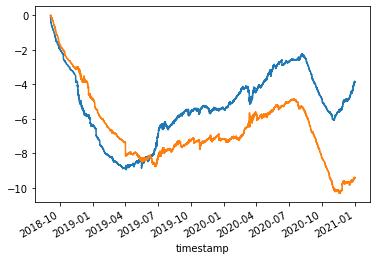

In [12]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                break
    return y

df = pd.read_pickle('df_features.pkl')

# FTX BTC-PERPだとpipsが時期で変化するので(0.25〜1くらい)、
# 約定シミュレーションは小さい単位でやって、指値計算は大きい単位でやる
min_pips = 0.001
max_pips = 1

# limit_price_dist = max_pips
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / max_pips).round().fillna(1)) * max_pips

df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

df['buy_fep'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=min_pips,
)

# calc_force_entry_priceは入力をマイナスにすれば売りに使える
df['sell_fep'] = -calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=min_pips,
)

horizon = 1
fee = 0.0

df['y_buy'] = np.where(
    (df['buy_price'] / min_pips).round() > (df['lo'].shift(-1) / min_pips).round(),
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    (df['sell_price'] / min_pips).round() < (df['hi'].shift(-1) / min_pips).round(),
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用
df['buy_cost'] = np.where(
    (df['buy_price'] / min_pips).round() > (df['lo'].shift(-1) / min_pips).round(),
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    (df['sell_price'] / min_pips).round() < (df['hi'].shift(-1) / min_pips).round(),
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

df['y_buy'].cumsum().plot()
df['y_sell'].cumsum().plot()
plt.show()

df.to_pickle('df_y.pkl')

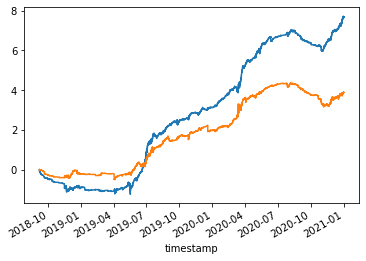

In [13]:
# 学習 + CV

df = pd.read_pickle('df_y.pkl')
df = df.dropna()

# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)
# model = BaggingRegressor(model, random_state=1, n_jobs=1)

# 厳密にはどちらもリーク(yに未来の区間のデータが含まれている)しているので注意
# 「ファイナンス機械学習」にCVについて詳しく書かれている

# 通常のCV
cv_indicies = KFold().split(df)
# ウォークフォワード法
# cv_indicies = TimeSeriesSplit().split(df)
                  
for train_idx2, val_idx2 in cv_indicies:
    train_idx = df.index[train_idx2]
    val_idx = df.index[val_idx2]
    model.fit(df.loc[train_idx, features], df.loc[train_idx, 'y_buy'])
    df.loc[val_idx, 'y_pred_buy'] = model.predict(df.loc[val_idx, features])
    model.fit(df.loc[train_idx, features], df.loc[train_idx, 'y_sell'])
    df.loc[val_idx, 'y_pred_sell'] = model.predict(df.loc[val_idx, features])

df = df.dropna()

df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot()
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot()
plt.show()

df.to_pickle('df_fit.pkl')

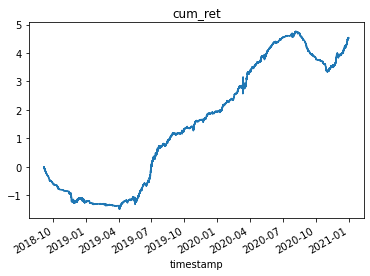

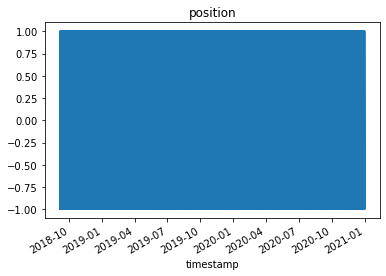

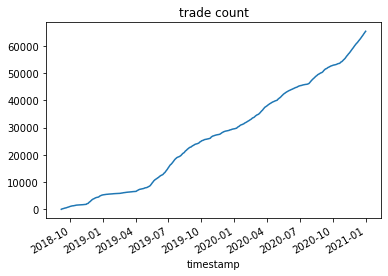

t検定
Ttest_1sampResult(statistic=5.030073206168592, pvalue=4.906594212144705e-07)
p平均法 https://note.com/btcml/n/n0d9575882640
p mean 0.4000121452949978
error rate 0.26670715344187046
error rateが十分小さくないと有意ではない(何度も試行錯誤することを考えると1e-5以下くらい)


In [14]:
# バックテスト + 検定
# 含み損によるゼロカットをシミュレーションしていないので注意

@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

df = pd.read_pickle('df_fit.pkl')

df['cum_ret'], df['poss'] = backtest(
    cl=df['cl'].values,
    buy_entry=df['y_pred_buy'].values > 0,
    sell_entry=df['y_pred_sell'].values > 0,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
)

df['cum_ret'].plot()
plt.title('cum_ret')
plt.show()

df['poss'].plot()
plt.title('position')
plt.show()

df['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('trade count')
plt.show()

print('t検定')

x = df['cum_ret'].diff(1).dropna()
print(ttest_1samp(x, 0))

print('p平均法 https://note.com/btcml/n/n0d9575882640')

def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p mean {}'.format(p_mean))
print('error rate {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))
print('error rateが十分小さくないと有意ではない(何度も試行錯誤することを考えると1e-5以下くらい)')